In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
from statsmodels.tsa.ar_model import AutoReg

In [2]:
# Đọc file và tiền xử lí dữ liệu
df = pd.read_csv('../data/VIB.csv')
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)
# Convert the Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
# Create a new column 'Day' as the number of days since the start date
df['Day'] = (df['Date'] - df['Date'].min()).dt.days

In [3]:
# Prepare features and target
X = df[['Day']]
y = df['Price']

# 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

# 
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train models
for model_name, model in models.items():
    model.fit(X_train, y_train)

# Make predictions
predictions = {model_name: model.predict(X_test) for model_name, model in models.items()}

# tính trọng số
def calculate_weights(models, X_test, y_test):
    errors = {}
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        errors[model_name] = np.mean(np.abs((y_test - y_pred) / y_test))
    total_error = sum(errors.values())
    weights = {model_name: (1 - error / total_error) for model_name, error in errors.items()}
    return weights

weights = calculate_weights(models, X_test, y_test)

# Calculate weighted average predictions
combined_predictions = np.zeros(len(X_test))
for model_name, prediction in predictions.items():
    combined_predictions += weights[model_name] * prediction



c:\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor

Predictions for the next 30 days: [41578.17294827 41571.47289303 41564.77283779 41558.07278255
 41551.37272731 41544.67267207 41537.97261683 41531.27256159
 41524.57250634 41517.8724511  41511.17239586 41504.47234062
 41497.77228538 41491.07223014 41484.3721749  41477.67211965
 41470.97206441 41464.27200917 41457.57195393 41450.87189869
 41444.17184345 41437.47178821 41430.77173297 41424.07167772
 41417.37162248 41410.67156724 41403.971512   41397.27145676
 41390.57140152 41383.87134628]
Predictions for the next 60 days: [41578.17294827 41571.47289303 41564.77283779 41558.07278255
 41551.37272731 41544.67267207 41537.97261683 41531.27256159
 41524.57250634 41517.8724511  41511.17239586 41504.47234062
 41497.77228538 41491.07223014 41484.3721749  41477.67211965
 41470.97206441 41464.27200917 41457.57195393 41450.87189869
 41444.17184345 41437.47178821 41430.77173297 41424.07167772
 41417.37162248 41410.67156724 41403.971512   41397.27145676
 41390.57140152 41383.87134628 41377.17129103 

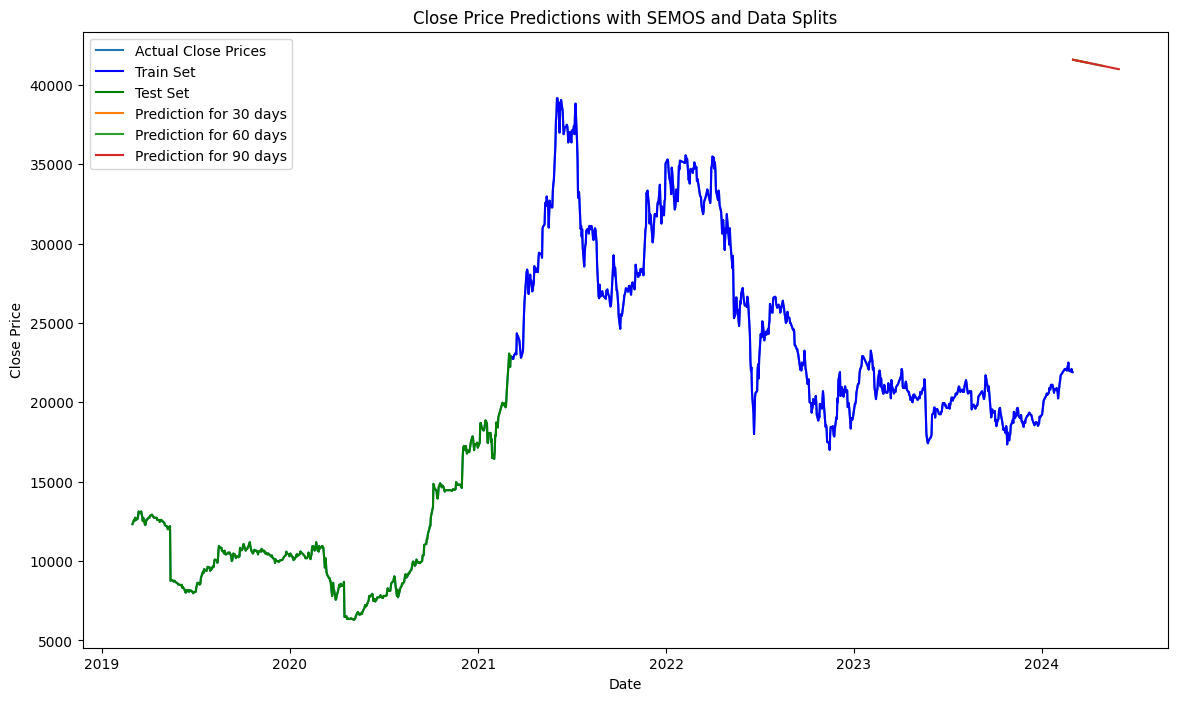

In [4]:
# Predict the future 'Close' prices for 30, 60, and 90 days
future_days = [30, 60, 90]
future_predictions = {}

last_day = X['Day'].max()
for days in future_days:
    future_X = np.array([last_day + i for i in range(1, days + 1)]).reshape(-1, 1)
    future_combined_predictions = np.zeros(len(future_X))
    for model_name, model in models.items():
        future_combined_predictions += weights[model_name] * model.predict(future_X)

    future_predictions[days] = future_combined_predictions

# Print daily predictions for 30, 60, and 90 days
for days, prediction in future_predictions.items():
    print(f"Predictions for the next {days} days: {prediction}")

# Plotting the results
plt.figure(figsize=(14, 8))
plt.plot(df['Date'], y, label='Actual Close Prices')

# Plot train and test sets
plt.plot(df['Date'][:len(X_train)], y_train, label='Train Set', color='blue')
plt.plot(df['Date'][len(X_train):], y_test, label='Test Set', color='green')

# Plot future predictions
for days, prediction in future_predictions.items():
    future_dates = [df['Date'].max() + pd.Timedelta(days=i) for i in range(1, days + 1)]
    plt.plot(future_dates, prediction, label=f'Prediction for {days} days')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price Predictions with SEMOS and Data Splits')
plt.legend()
plt.show()